# Tirumala 6-Band Crowd Prediction — Model Evaluation
**Confusion matrix & classification metrics on all data WITHOUT COVID (pre-COVID + post-COVID)**

Bands: QUIET · LIGHT · MODERATE · BUSY · HEAVY · EXTREME

In [1]:
import json, pathlib
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    accuracy_score, balanced_accuracy_score
)
from festival_calendar import get_festival_features_series

print("Libraries loaded ✓")

Libraries loaded ✓


## 1. Load Model Artefacts & Dataset

In [2]:
# ── Load model artefacts ──
ART_DIR = pathlib.Path("artefacts/advisory_v5")

lgb_model = joblib.load(ART_DIR / "lgb_model.pkl")
xgb_model = joblib.load(ART_DIR / "xgb_model.pkl")

with open(ART_DIR / "model_meta.json") as f:
    META = json.load(f)
with open(ART_DIR / "hyperparams.json") as f:
    HYPER = json.load(f)

FEATURE_COLS = META["feature_cols"]
BANDS        = META["bands"]
BAND_NAMES   = META["band_names"]
N_BANDS      = META["n_bands"]
BEST_ALPHA   = HYPER.get("best_alpha", 0.5)
POST_COVID   = META["post_covid"]

print(f"Models loaded from: {ART_DIR}")
print(f"Features: {len(FEATURE_COLS)}")
print(f"Bands: {BAND_NAMES}")
print(f"Alpha (LGB weight): {BEST_ALPHA}")
print(f"Post-COVID cutoff: {POST_COVID}")

Models loaded from: artefacts\advisory_v5
Features: 54
Bands: ['QUIET', 'LIGHT', 'MODERATE', 'BUSY', 'HEAVY', 'EXTREME']
Alpha (LGB weight): 0.3
Post-COVID cutoff: 2022-02-01


## 2. Load & Filter Data (Exclude COVID Period Only)

In [13]:
# ── Load full data, exclude only the COVID lockdown period ──
COVID_START = "2020-03-01"
COVID_END   = "2022-01-31"

df = pd.read_csv(META["data_file"], parse_dates=["date"])
print(f"Full dataset:  {len(df)} rows  ({df.date.min().date()} → {df.date.max().date()})")

covid_mask = (df.date >= COVID_START) & (df.date <= COVID_END)
print(f"COVID period:  {covid_mask.sum()} rows removed  ({COVID_START} → {COVID_END})")

df = df[~covid_mask].sort_values("date").reset_index(drop=True)
print(f"Without COVID: {len(df)} rows  ({df.date.min().date()} → {df.date.max().date()})")

# Assign actual band labels
def pilgrims_to_band(val):
    for i, b in enumerate(BANDS):
        if b["lo"] <= val < b["hi"]:
            return i
    return N_BANDS - 1

df["actual_band"] = df["total_pilgrims"].apply(pilgrims_to_band)
print(f"\nActual band distribution:")
for i, name in enumerate(BAND_NAMES):
    count = (df["actual_band"] == i).sum()
    print(f"  {name:10s}: {count:4d}  ({count/len(df)*100:5.1f}%)")

Full dataset:  4069 rows  (2013-10-17 → 2026-02-13)
COVID period:  604 rows removed  (2020-03-01 → 2022-01-31)
Without COVID: 3465 rows  (2013-10-17 → 2026-02-13)

Actual band distribution:
  QUIET     :  133  (  3.8%)
  LIGHT     :  456  ( 13.2%)
  MODERATE  : 1168  ( 33.7%)
  BUSY      : 1045  ( 30.2%)
  HEAVY     :  520  ( 15.0%)
  EXTREME   :  143  (  4.1%)


## 3. Build Feature Matrix & Generate Predictions
Walk through the data day-by-day, using real historical pilgrim counts as lag features (just like the production model does).

In [14]:
def build_features_for_date(fdate, history_vals, dow_means):
    """Mirror the production build_single_features from flask_api.py."""
    row = {}
    row["dow"]        = fdate.weekday()
    row["month"]      = fdate.month
    row["is_weekend"] = 1 if fdate.weekday() >= 5 else 0
    doy = fdate.timetuple().tm_yday
    row["sin_doy"] = np.sin(2 * np.pi * doy / 365.25)
    row["cos_doy"] = np.cos(2 * np.pi * doy / 365.25)

    n = len(history_vals)
    for lag in [1, 2, 7, 14, 21, 28]:
        idx = n - lag
        row[f"L{lag}"] = history_vals[idx] if idx >= 0 else history_vals[0]
    for w in [7, 14, 30]:
        vals = history_vals[max(0, n - w):]
        row[f"rm{w}"] = np.mean(vals)
    row["rstd7"]  = np.std(history_vals[-7:])  if n >= 7  else 0
    row["rstd14"] = np.std(history_vals[-14:]) if n >= 14 else 0
    row["dow_expanding_mean"] = dow_means.get(fdate.weekday(), 70000)

    row["log_L1"]   = np.log1p(row["L1"])
    row["log_L7"]   = np.log1p(row["L7"])
    row["log_rm7"]  = np.log1p(row["rm7"])
    row["log_rm30"] = np.log1p(row["rm30"])

    row["momentum_7"] = row["L1"] - row["L7"]
    row["dow_dev"]    = row["L1"] - row["dow_expanding_mean"]

    row["month_dow"]   = row["month"] * 10 + row["dow"]
    vals7 = history_vals[-7:]
    w7 = np.exp(np.linspace(-1, 0, len(vals7)))
    row["ewm7"]  = np.average(vals7, weights=w7) if len(vals7) > 0 else row["rm7"]
    vals14 = history_vals[-14:]
    w14 = np.exp(np.linspace(-1, 0, len(vals14)))
    row["ewm14"] = np.average(vals14, weights=w14) if len(vals14) > 0 else row.get("rm14", row["rm7"])
    row["trend_7_14"] = row["rm7"] - row["rm14"]
    row["trend_7_30"] = row["rm7"] - row["rm30"]
    row["week_of_year"] = fdate.isocalendar()[1]
    idx365 = n - 365
    row["L365"]     = history_vals[idx365] if idx365 >= 0 else history_vals[0]
    row["log_L365"] = np.log1p(row["L365"])

    recent = history_vals[-8:-1] if n >= 8 else history_vals[-7:]
    recent_bands = [pilgrims_to_band(v) for v in recent]
    row["heavy_extreme_count7"] = sum(1 for b in recent_bands if b >= 4)
    row["light_quiet_count7"]   = sum(1 for b in recent_bands if b <= 1)

    fest = get_festival_features_series(pd.Series([pd.Timestamp(fdate)]))
    keep_fest = [
        "is_festival", "fest_impact", "is_brahmotsavam", "is_sankranti",
        "is_summer_holiday", "is_dasara_holiday", "is_national_holiday",
        "days_to_fest", "days_from_fest", "fest_window_7",
        "is_vaikuntha_ekadashi", "is_dussehra_period", "is_diwali",
        "is_navaratri", "is_janmashtami", "is_ugadi", "is_rathasapthami",
        "is_ramanavami", "is_shivaratri", "is_winter_holiday",
        "fest_window_3",
    ]
    for c in keep_fest:
        row[c] = fest[c].values[0] if c in fest.columns else 0

    return np.array([[row.get(f, 0) for f in FEATURE_COLS]])


# ── Walk through data & predict each day using real history ──
MIN_HISTORY = 30  # need at least 30 days of history for features
history = list(df["total_pilgrims"].values[:MIN_HISTORY])

# Build expanding DOW means
dow_sums = {}
dow_counts = {}

y_true, y_pred, pred_confs, dates_eval = [], [], [], []

for i in range(MIN_HISTORY, len(df)):
    row = df.iloc[i]
    fdate = row["date"].to_pydatetime()
    
    # Update DOW expanding means up to yesterday
    prev = df.iloc[i-1]
    d = prev["date"].to_pydatetime().weekday()
    dow_sums[d] = dow_sums.get(d, 0) + prev["total_pilgrims"]
    dow_counts[d] = dow_counts.get(d, 0) + 1
    dow_means = {k: dow_sums[k] / dow_counts[k] for k in dow_sums}
    
    # Build features and predict
    X = build_features_for_date(fdate, history, dow_means)
    lgb_prob = lgb_model.predict_proba(X)
    xgb_prob = xgb_model.predict_proba(X)
    vote_prob = BEST_ALPHA * lgb_prob + (1 - BEST_ALPHA) * xgb_prob
    pred = int(vote_prob.argmax(axis=1)[0])
    conf = float(vote_prob[0][pred])
    
    y_true.append(row["actual_band"])
    y_pred.append(pred)
    pred_confs.append(conf)
    dates_eval.append(fdate)
    
    # Add actual value to history for next day's features
    history.append(row["total_pilgrims"])

print(f"Evaluated {len(y_true)} days (skipped first {MIN_HISTORY} for warm-up)")
print(f"Date range: {dates_eval[0].date()} → {dates_eval[-1].date()}")

c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.w

Evaluated 3435 days (skipped first 30 for warm-up)
Date range: 2013-11-20 → 2026-02-13


c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.w

## 4. Confusion Matrix (Counts)

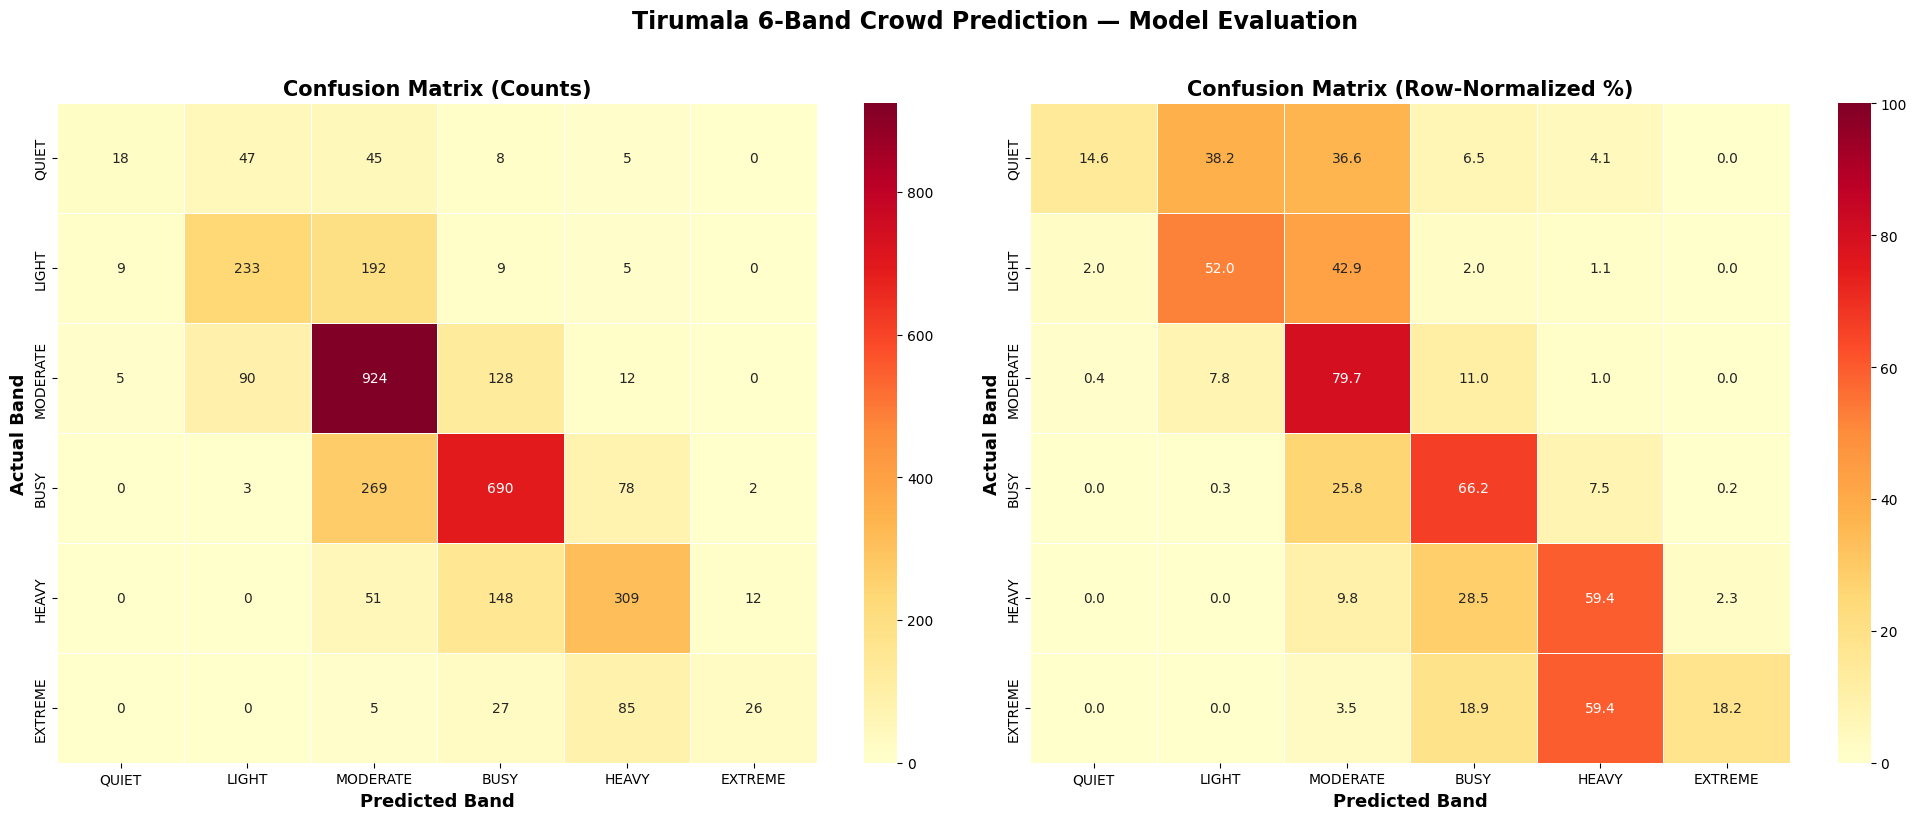

Saved: confusion_matrix_evaluation.png


In [15]:
# ── Confusion Matrix ──
cm = confusion_matrix(y_true, y_pred, labels=list(range(N_BANDS)))

BAND_COLORS_HEX = ["#2196F3", "#4CAF50", "#8BC34A", "#FFC107", "#FF5722", "#B71C1C"]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ── Left: Raw counts ──
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd",
            xticklabels=BAND_NAMES, yticklabels=BAND_NAMES,
            linewidths=0.5, linecolor="white",
            ax=axes[0])
axes[0].set_xlabel("Predicted Band", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Actual Band", fontsize=13, fontweight="bold")
axes[0].set_title("Confusion Matrix (Counts)", fontsize=15, fontweight="bold")

# ── Right: Normalized (row %) ──
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="YlOrRd",
            xticklabels=BAND_NAMES, yticklabels=BAND_NAMES,
            linewidths=0.5, linecolor="white",
            ax=axes[1], vmin=0, vmax=100)
axes[1].set_xlabel("Predicted Band", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Actual Band", fontsize=13, fontweight="bold")
axes[1].set_title("Confusion Matrix (Row-Normalized %)", fontsize=15, fontweight="bold")

plt.suptitle("Tirumala 6-Band Crowd Prediction — Model Evaluation",
             fontsize=17, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("confusion_matrix_evaluation.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: confusion_matrix_evaluation.png")

## 5. Classification Report & Metrics

In [16]:
# ── Classification report ──
print("=" * 72)
print("  CLASSIFICATION REPORT — 6-Band Crowd Prediction")
print("=" * 72)
report = classification_report(y_true, y_pred, target_names=BAND_NAMES,
                               labels=list(range(N_BANDS)), zero_division=0)
print(report)

acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"  Overall Accuracy:    {acc:.4f}  ({acc*100:.1f}%)")
print(f"  Balanced Accuracy:   {bal_acc:.4f}  ({bal_acc*100:.1f}%)")

# ── Adjacent accuracy (off by at most 1 band) ──
adj_correct = sum(1 for t, p in zip(y_true, y_pred) if abs(t - p) <= 1)
adj_acc = adj_correct / len(y_true)
print(f"  Adjacent Accuracy:   {adj_acc:.4f}  ({adj_acc*100:.1f}%)  (±1 band)")
print(f"  Mean Confidence:     {np.mean(pred_confs):.3f}")
print("=" * 72)

  CLASSIFICATION REPORT — 6-Band Crowd Prediction
              precision    recall  f1-score   support

       QUIET       0.56      0.15      0.23       123
       LIGHT       0.62      0.52      0.57       448
    MODERATE       0.62      0.80      0.70      1159
        BUSY       0.68      0.66      0.67      1042
       HEAVY       0.63      0.59      0.61       520
     EXTREME       0.65      0.18      0.28       143

    accuracy                           0.64      3435
   macro avg       0.63      0.48      0.51      3435
weighted avg       0.64      0.64      0.63      3435

  Overall Accuracy:    0.6405  (64.0%)
  Balanced Accuracy:   0.4837  (48.4%)
  Adjacent Accuracy:   0.9485  (94.8%)  (±1 band)
  Mean Confidence:     0.810


## 6. Per-Band Accuracy Breakdown

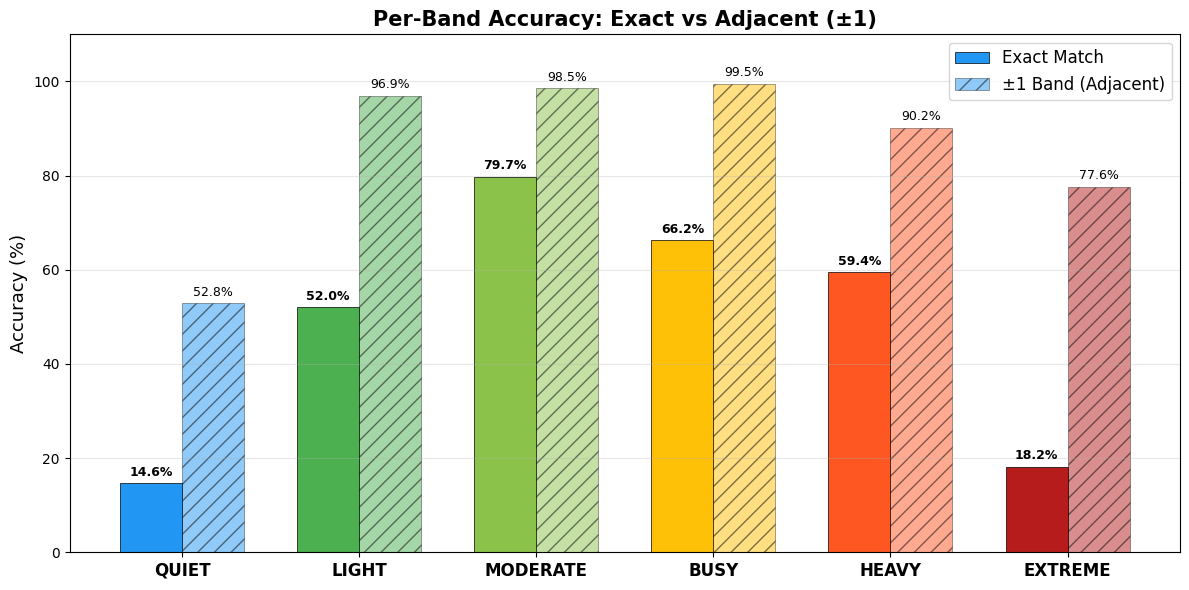

Saved: per_band_accuracy.png


In [17]:
# ── Per-band accuracy bar chart ──
per_band_acc = []
per_band_adj = []
for i, name in enumerate(BAND_NAMES):
    mask = [t == i for t in y_true]
    total = sum(mask)
    if total == 0:
        per_band_acc.append(0)
        per_band_adj.append(0)
        continue
    correct = sum(1 for t, p in zip(y_true, y_pred) if t == i and p == i)
    adj = sum(1 for t, p in zip(y_true, y_pred) if t == i and abs(t - p) <= 1)
    per_band_acc.append(correct / total * 100)
    per_band_adj.append(adj / total * 100)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(N_BANDS)
width = 0.35

bars1 = ax.bar(x - width/2, per_band_acc, width, label="Exact Match",
               color=BAND_COLORS_HEX, edgecolor="black", linewidth=0.5)
bars2 = ax.bar(x + width/2, per_band_adj, width, label="±1 Band (Adjacent)",
               color=BAND_COLORS_HEX, alpha=0.5, edgecolor="black", linewidth=0.5,
               hatch="//")

# Add value labels on bars
for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%",
            ha="center", va="bottom", fontsize=9, fontweight="bold")
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 1, f"{h:.1f}%",
            ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(BAND_NAMES, fontsize=12, fontweight="bold")
ax.set_ylabel("Accuracy (%)", fontsize=13)
ax.set_title("Per-Band Accuracy: Exact vs Adjacent (±1)", fontsize=15, fontweight="bold")
ax.legend(fontsize=12)
ax.set_ylim(0, 110)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("per_band_accuracy.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: per_band_accuracy.png")

## 7. Error Distribution — How Far Off Are Predictions?

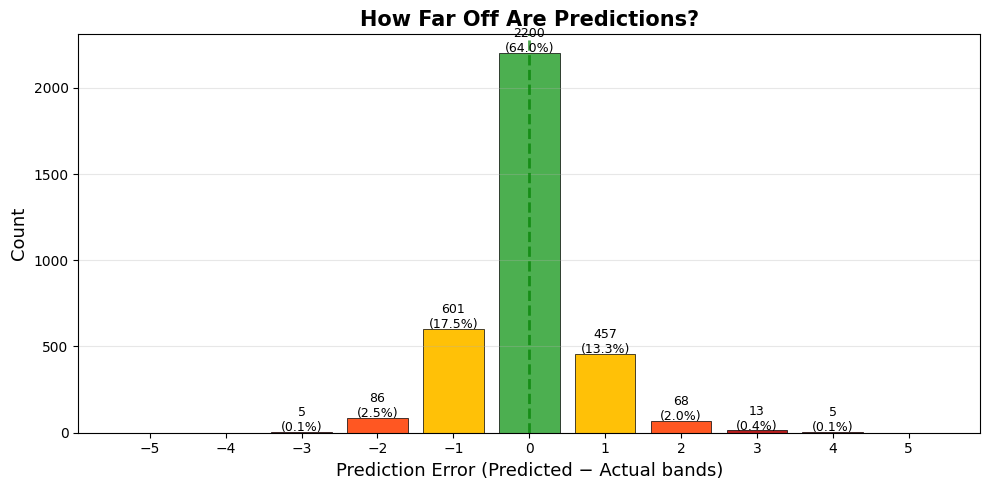


Exact:   2200 (64.0%)
Off ±1:  3258 (94.8%)
Off ±2+:  177 (5.2%)


In [18]:
# ── Error distribution ──
errors = [p - t for t, p in zip(y_true, y_pred)]
err_counts = {}
for e in range(-5, 6):
    err_counts[e] = errors.count(e)

fig, ax = plt.subplots(figsize=(10, 5))
labels = list(err_counts.keys())
values = list(err_counts.values())
colors = ["#B71C1C" if abs(l) >= 3 else "#FF5722" if abs(l) == 2 else "#FFC107" if abs(l) == 1 else "#4CAF50" for l in labels]

ax.bar(labels, values, color=colors, edgecolor="black", linewidth=0.5)
for l, v in zip(labels, values):
    if v > 0:
        ax.text(l, v + 5, f"{v}\n({v/len(errors)*100:.1f}%)", ha="center", fontsize=9)

ax.set_xlabel("Prediction Error (Predicted − Actual bands)", fontsize=13)
ax.set_ylabel("Count", fontsize=13)
ax.set_title("How Far Off Are Predictions?", fontsize=15, fontweight="bold")
ax.axvline(0, color="green", linestyle="--", alpha=0.7, linewidth=2)
ax.set_xticks(range(-5, 6))
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("prediction_error_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\nExact:   {err_counts[0]:4d} ({err_counts[0]/len(errors)*100:.1f}%)")
print(f"Off ±1:  {err_counts[-1]+err_counts[0]+err_counts[1]:4d} ({(err_counts[-1]+err_counts[0]+err_counts[1])/len(errors)*100:.1f}%)")
print(f"Off ±2+: {sum(v for l,v in err_counts.items() if abs(l)>=2):4d} ({sum(v for l,v in err_counts.items() if abs(l)>=2)/len(errors)*100:.1f}%)")

## 8. Class Distribution — Actual vs Predicted (Total & Year-by-Year)

In [21]:
# ── Build evaluation DataFrame ──
eval_df = pd.DataFrame({
    "date": dates_eval,
    "actual": y_true,
    "predicted": y_pred,
})
eval_df["year"] = eval_df["date"].apply(lambda d: d.year)

# ═══════════════════════════════════════════════════════════════
#  ACTUAL CLASS DISTRIBUTION — Total & Year-by-Year
# ═══════════════════════════════════════════════════════════════
print("=" * 90)
print("  ACTUAL CLASS DISTRIBUTION (% of days)")
print("=" * 90)

years = sorted(eval_df["year"].unique())

# Header
hdr = f"{'Band':>10s} │ {'TOTAL':>8s}"
for y in years:
    hdr += f" │ {y:>6d}"
print(hdr)
print("─" * len(hdr))

for band_i, band_name in enumerate(BAND_NAMES):
    total_count = (eval_df["actual"] == band_i).sum()
    total_pct = total_count / len(eval_df) * 100
    row_str = f"{band_name:>10s} │ {total_pct:7.1f}%"
    for y in years:
        yr_df = eval_df[eval_df["year"] == y]
        yr_count = (yr_df["actual"] == band_i).sum()
        yr_pct = yr_count / len(yr_df) * 100 if len(yr_df) > 0 else 0
        row_str += f" │ {yr_pct:5.1f}%"
    print(row_str)

# Total row
row_str = f"{'DAYS':>10s} │ {len(eval_df):>7d} "
for y in years:
    yr_df = eval_df[eval_df["year"] == y]
    row_str += f" │ {len(yr_df):>5d} "
print("─" * len(hdr))
print(row_str)

# ═══════════════════════════════════════════════════════════════
#  PREDICTED CLASS DISTRIBUTION — Total & Year-by-Year
# ═══════════════════════════════════════════════════════════════
print("\n" + "=" * 90)
print("  PREDICTED CLASS DISTRIBUTION (% of days)")
print("=" * 90)

print(hdr)
print("─" * len(hdr))

for band_i, band_name in enumerate(BAND_NAMES):
    total_count = (eval_df["predicted"] == band_i).sum()
    total_pct = total_count / len(eval_df) * 100
    row_str = f"{band_name:>10s} │ {total_pct:7.1f}%"
    for y in years:
        yr_df = eval_df[eval_df["year"] == y]
        yr_count = (yr_df["predicted"] == band_i).sum()
        yr_pct = yr_count / len(yr_df) * 100 if len(yr_df) > 0 else 0
        row_str += f" │ {yr_pct:5.1f}%"
    print(row_str)

row_str = f"{'DAYS':>10s} │ {len(eval_df):>7d} "
for y in years:
    yr_df = eval_df[eval_df["year"] == y]
    row_str += f" │ {len(yr_df):>5d} "
print("─" * len(hdr))
print(row_str)

  ACTUAL CLASS DISTRIBUTION (% of days)
      Band │    TOTAL │   2013 │   2014 │   2015 │   2016 │   2017 │   2018 │   2019 │   2020 │   2022 │   2023 │   2024 │   2025 │   2026
──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     QUIET │     3.6% │  31.4% │   9.3% │   8.0% │   0.8% │   1.7% │   1.8% │   0.8% │   0.0% │   8.1% │   1.9% │   0.6% │   0.3% │   0.0%
     LIGHT │    13.0% │  31.4% │  35.6% │  21.1% │  15.8% │   6.9% │   7.0% │   5.8% │   1.7% │   6.3% │  12.4% │   9.4% │   8.0% │   0.0%
  MODERATE │    33.7% │  28.6% │  29.4% │  31.6% │  27.4% │  30.8% │  37.9% │  29.1% │  48.3% │  35.9% │  37.5% │  42.9% │  32.7% │  34.9%
      BUSY │    30.3% │   8.6% │  23.0% │  20.8% │  26.0% │  28.5% │  33.0% │  32.2% │  25.9% │  34.7% │  35.3% │  33.2% │  39.3% │  39.5%
     HEAVY │    15.1% │   0.0% │   2.6% │  14.2% │  22.3% │  21.9% │  15.0% │  20.5% │  17.2% │  13.2% │  12.7% │  13.6% │  16

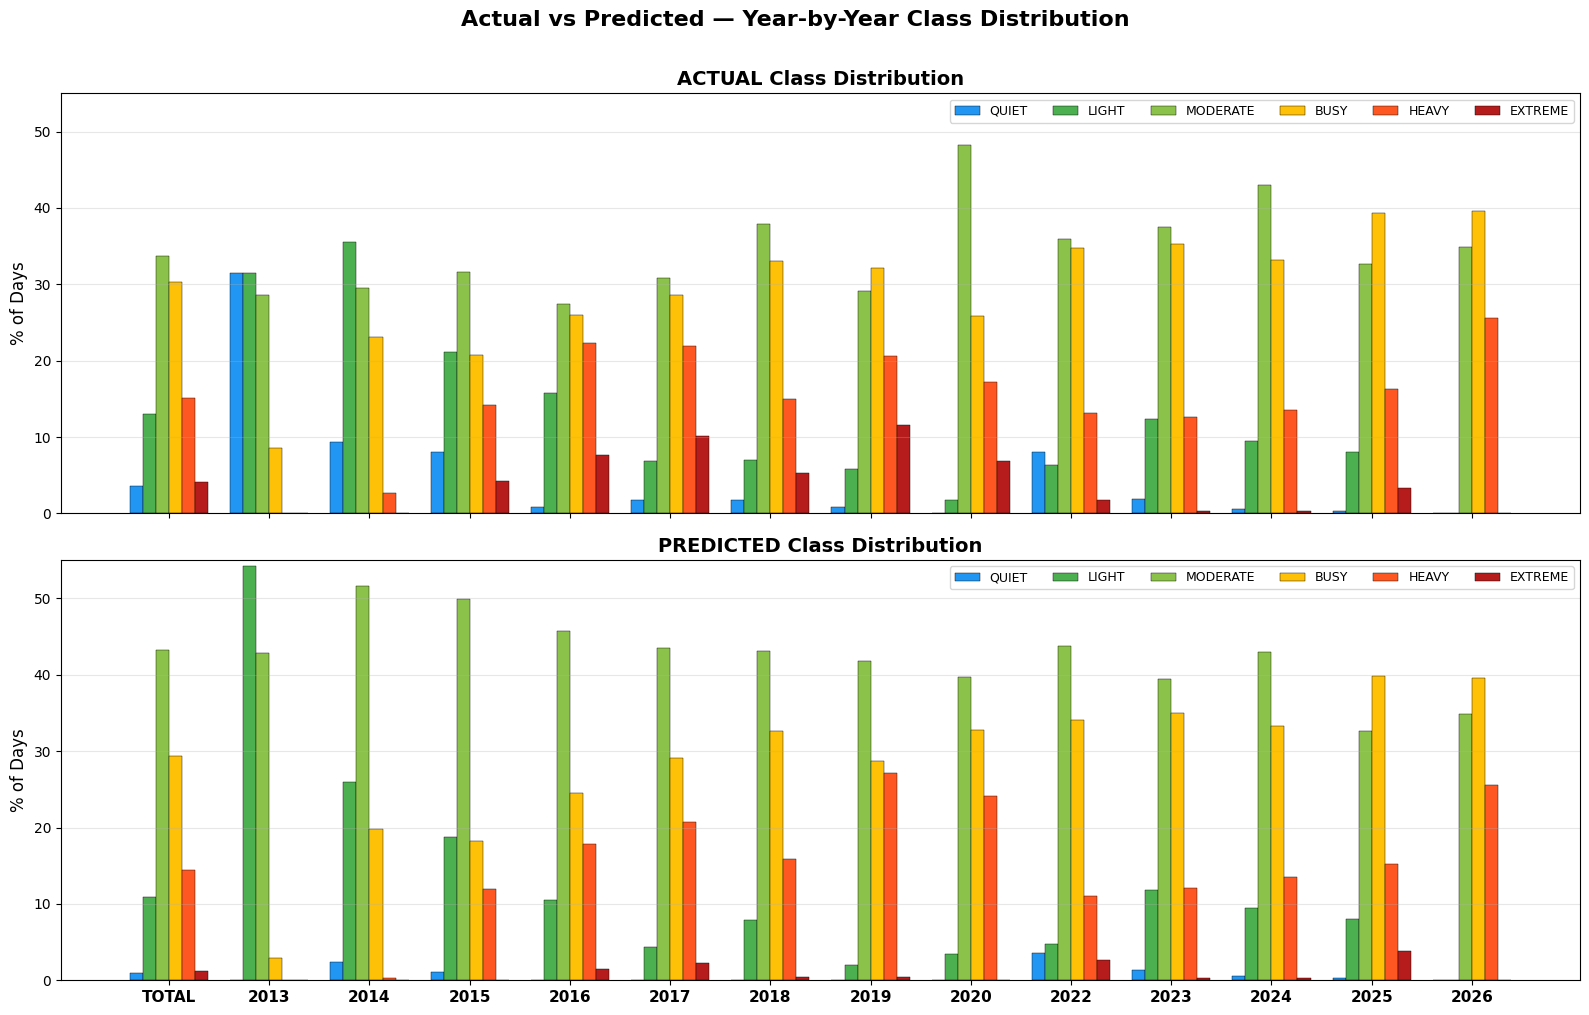


  ACCURACY BY YEAR
    Year │  Days │   Exact │  ±1 Band
  ───────────────────────────────────
    2013 │    35 │   31.4% │    94.3%
    2014 │   343 │   47.5% │    95.6%
    2015 │   351 │   46.4% │    90.6%
    2016 │   354 │   44.9% │    91.5%
    2017 │   347 │   49.6% │    92.5%
    2018 │   227 │   44.5% │    93.4%
    2019 │   258 │   49.6% │    91.5%
    2020 │    58 │   53.4% │    86.2%
    2022 │   334 │   50.9% │    92.5%
    2023 │   363 │   94.5% │    99.7%
    2024 │   361 │   99.4% │   100.0%
    2025 │   361 │   98.9% │   100.0%
    2026 │    43 │  100.0% │   100.0%
  ───────────────────────────────────
   TOTAL │  3435 │   64.0% │    94.8%


In [22]:
# ── Visual: Actual vs Predicted distribution by year ──
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

years_all = ["TOTAL"] + [str(y) for y in years]
x_pos = np.arange(len(years_all))
bar_w = 0.13

for band_i, band_name in enumerate(BAND_NAMES):
    # Actual
    vals_actual = []
    vals_actual.append((eval_df["actual"] == band_i).sum() / len(eval_df) * 100)
    for y in years:
        yr_df = eval_df[eval_df["year"] == y]
        vals_actual.append((yr_df["actual"] == band_i).sum() / len(yr_df) * 100 if len(yr_df) else 0)
    axes[0].bar(x_pos + band_i * bar_w - 2.5 * bar_w, vals_actual, bar_w,
                label=band_name, color=BAND_COLORS_HEX[band_i], edgecolor="black", linewidth=0.3)
    
    # Predicted
    vals_pred = []
    vals_pred.append((eval_df["predicted"] == band_i).sum() / len(eval_df) * 100)
    for y in years:
        yr_df = eval_df[eval_df["year"] == y]
        vals_pred.append((yr_df["predicted"] == band_i).sum() / len(yr_df) * 100 if len(yr_df) else 0)
    axes[1].bar(x_pos + band_i * bar_w - 2.5 * bar_w, vals_pred, bar_w,
                label=band_name, color=BAND_COLORS_HEX[band_i], edgecolor="black", linewidth=0.3)

for ax, title in zip(axes, ["ACTUAL Class Distribution", "PREDICTED Class Distribution"]):
    ax.set_ylabel("% of Days", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(years_all, fontsize=11, fontweight="bold")
    ax.legend(loc="upper right", fontsize=9, ncol=6)
    ax.grid(axis="y", alpha=0.3)
    ax.set_ylim(0, 55)

plt.suptitle("Actual vs Predicted — Year-by-Year Class Distribution",
             fontsize=16, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("class_distribution_yearly.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Accuracy by year ──
print("\n" + "=" * 60)
print("  ACCURACY BY YEAR")
print("=" * 60)
print(f"  {'Year':>6s} │ {'Days':>5s} │ {'Exact':>7s} │ {'±1 Band':>8s}")
print("  " + "─" * 35)
for y in years:
    yr_df = eval_df[eval_df["year"] == y]
    exact = (yr_df["actual"] == yr_df["predicted"]).sum() / len(yr_df) * 100
    adj = sum(1 for _, r in yr_df.iterrows() if abs(r["actual"] - r["predicted"]) <= 1) / len(yr_df) * 100
    print(f"  {y:>6d} │ {len(yr_df):>5d} │ {exact:6.1f}% │ {adj:7.1f}%")
exact_all = (eval_df["actual"] == eval_df["predicted"]).sum() / len(eval_df) * 100
adj_all = sum(1 for _, r in eval_df.iterrows() if abs(r["actual"] - r["predicted"]) <= 1) / len(eval_df) * 100
print("  " + "─" * 35)
print(f"  {'TOTAL':>6s} │ {len(eval_df):>5d} │ {exact_all:6.1f}% │ {adj_all:7.1f}%")

c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ML_PROJECTS\tirumala\.venv_dl\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.w

  FULL 2026 PREDICTIONS — 365 days
  (43 days with actual data  +  322 days forecasted)

  FULL YEAR 2026 — PREDICTED CLASS DISTRIBUTION (365 days)
        Band │   Days       % │ Bar
  ───────────────────────────────────────────────────────
       QUIET │     0    0.0% │ 
       LIGHT │     7    1.9% │ 
    MODERATE │   138   37.8% │ ██████████████████
        BUSY │   149   40.8% │ ████████████████████
       HEAVY │    67   18.4% │ █████████
     EXTREME │     4    1.1% │ 
  ───────────────────────────────────────────────────────
       TOTAL │   365  100.0% │

  MONTH-BY-MONTH PREDICTED DISTRIBUTION (% of days in each month)
  Month │ Days │    QUIET │    LIGHT │ MODERATE │     BUSY │    HEAVY │  EXTREME
  ────────────────────────────────────────────────────────────────────────────────
    Jan │   31 │    0.0% │    0.0% │   25.8% │   45.2% │   29.0% │    0.0%
    Feb │   28 │    0.0% │    0.0% │   57.1% │   32.1% │   10.7% │    0.0%
    Mar │   31 │    0.0% │    6.5% │   64.5% │   

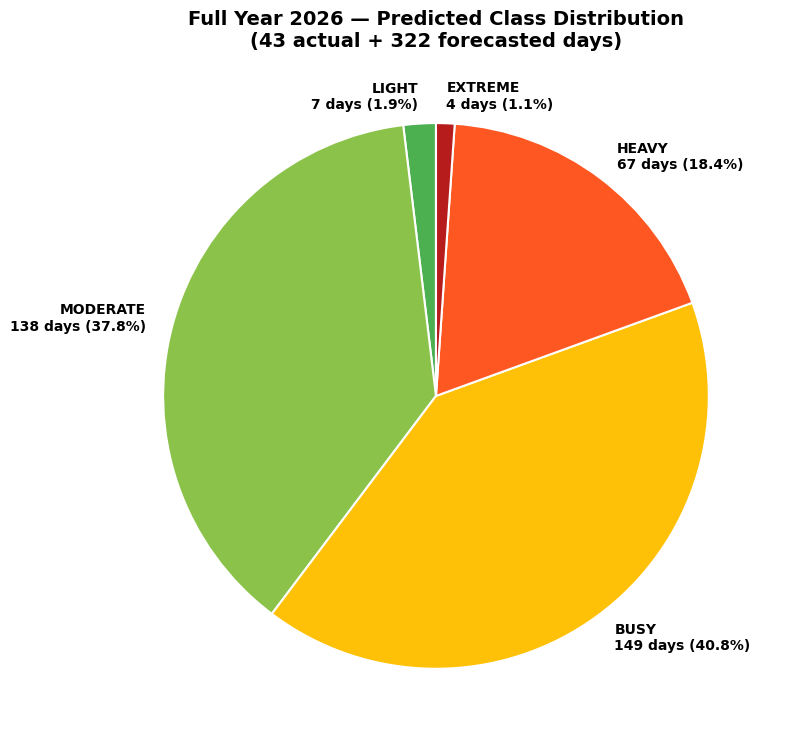

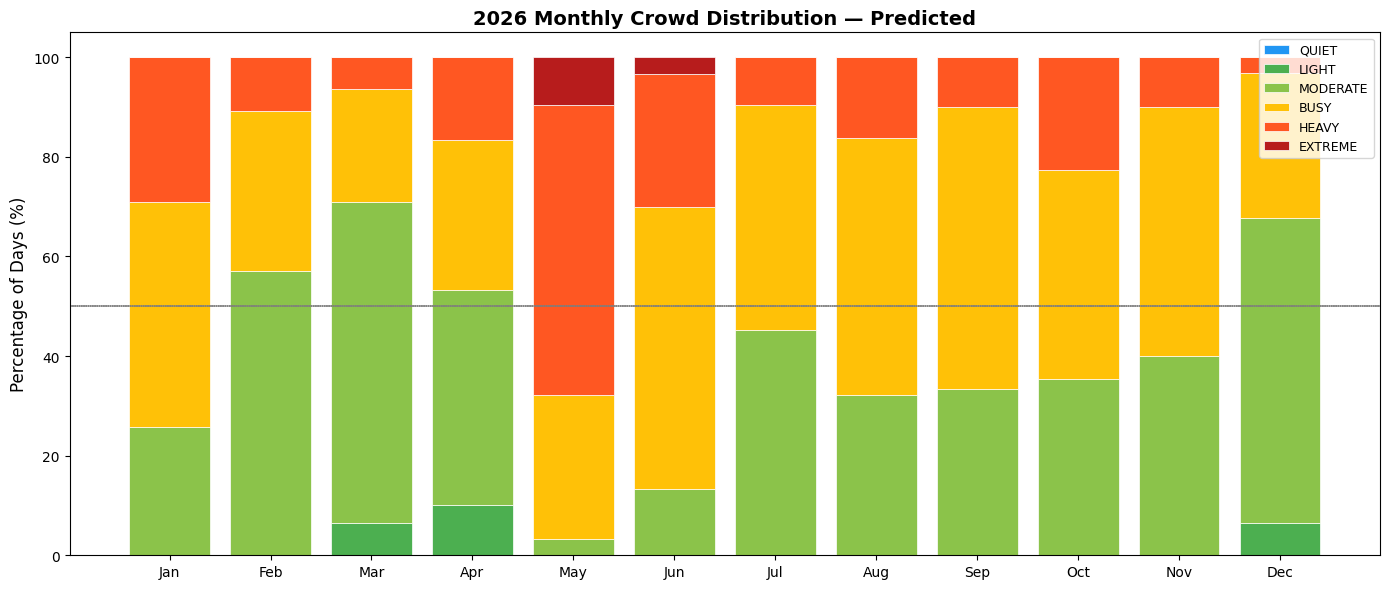

In [24]:
# ── Full 2026 Predictions (Jan 1 → Dec 31) ──
# For days WITH actual data: use real predictions from eval_df
# For FUTURE days (beyond data): autoregressive forecast using band midpoints

from datetime import datetime, timedelta

# Band midpoints — used as synthetic "pilgrim count" when forecasting future days
band_mids = [(b["lo"] + min(b["hi"], 120000)) / 2 for b in BANDS]

# ── Build history from ALL non-COVID data up to last available date ──
last_data_date = df["date"].max().to_pydatetime()
full_history = list(df["total_pilgrims"].values)

# Rebuild DOW means from full data
fut_dow_sums, fut_dow_counts = {}, {}
for _, r in df.iterrows():
    d = r["date"].weekday()
    fut_dow_sums[d] = fut_dow_sums.get(d, 0) + r["total_pilgrims"]
    fut_dow_counts[d] = fut_dow_counts.get(d, 0) + 1
fut_dow_means = {k: fut_dow_sums[k] / fut_dow_counts[k] for k in fut_dow_sums}

# ── Existing 2026 predictions (from eval_df) ──
known_2026 = eval_df[eval_df["year"] == 2026].copy()
known_dates = set(known_2026["date"].dt.date)

# ── Generate predictions for every day in 2026 ──
all_2026 = []
start_2026 = datetime(2026, 1, 1)
end_2026   = datetime(2026, 12, 31)

cur = start_2026
forecast_history = full_history.copy()
forecast_dow_means = fut_dow_means.copy()

while cur <= end_2026:
    dt_date = cur.date() if hasattr(cur, 'date') else cur
    
    if pd.Timestamp(cur).date() in known_dates:
        # Use real actual + real prediction
        row_data = known_2026[known_2026["date"].dt.date == pd.Timestamp(cur).date()].iloc[0]
        pred_band = int(row_data["predicted"])
        actual_band_val = int(row_data["actual"])
        source = "actual"
        # Use real pilgrim count for history
        real_row = df[df["date"].dt.date == pd.Timestamp(cur).date()]
        if len(real_row) > 0:
            pilgrim_val = real_row.iloc[0]["total_pilgrims"]
        else:
            pilgrim_val = band_mids[pred_band]
    else:
        # FUTURE — autoregressive forecast
        X = build_features_for_date(cur, forecast_history, forecast_dow_means)
        lgb_prob = lgb_model.predict_proba(X)
        xgb_prob = xgb_model.predict_proba(X)
        vote_prob = BEST_ALPHA * lgb_prob + (1 - BEST_ALPHA) * xgb_prob
        pred_band = int(vote_prob.argmax(axis=1)[0])
        actual_band_val = None
        source = "forecast"
        pilgrim_val = band_mids[pred_band]
    
    # Update history & DOW means for next iteration
    forecast_history.append(pilgrim_val)
    dow_key = cur.weekday()
    forecast_dow_means[dow_key] = (
        fut_dow_sums.get(dow_key, 0) + pilgrim_val
    ) / (fut_dow_counts.get(dow_key, 0) + 1)
    
    all_2026.append({
        "date": cur,
        "predicted": pred_band,
        "predicted_name": BAND_NAMES[pred_band],
        "actual": actual_band_val,
        "actual_name": BAND_NAMES[actual_band_val] if actual_band_val is not None else "—",
        "source": source
    })
    cur += timedelta(days=1)

df_full_2026 = pd.DataFrame(all_2026)
n_total = len(df_full_2026)
n_actual = (df_full_2026["source"] == "actual").sum()
n_forecast = (df_full_2026["source"] == "forecast").sum()

print("=" * 80)
print(f"  FULL 2026 PREDICTIONS — {n_total} days")
print(f"  ({n_actual} days with actual data  +  {n_forecast} days forecasted)")
print("=" * 80)

# ── Class distribution for full year ──
print(f"\n{'=' * 65}")
print(f"  FULL YEAR 2026 — PREDICTED CLASS DISTRIBUTION ({n_total} days)")
print(f"{'=' * 65}")
print(f"  {'Band':>10s} │ {'Days':>6s} {'%':>7s} │ {'Bar'}")
print("  " + "─" * 55)
for i, name in enumerate(BAND_NAMES):
    count = (df_full_2026["predicted"] == i).sum()
    pct = count / n_total * 100
    bar = "█" * int(pct / 2)
    print(f"  {name:>10s} │ {count:>5d}  {pct:5.1f}% │ {bar}")
print("  " + "─" * 55)
print(f"  {'TOTAL':>10s} │ {n_total:>5d}  100.0% │")

# ── Month-by-month breakdown ──
df_full_2026["month"] = df_full_2026["date"].apply(lambda d: d.month)
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

print(f"\n{'=' * 85}")
print(f"  MONTH-BY-MONTH PREDICTED DISTRIBUTION (% of days in each month)")
print(f"{'=' * 85}")
hdr = f"  {'Month':>5s} │ {'Days':>4s}"
for name in BAND_NAMES:
    hdr += f" │ {name:>8s}"
print(hdr)
print("  " + "─" * 80)

for m in range(1, 13):
    mdf = df_full_2026[df_full_2026["month"] == m]
    mlen = len(mdf)
    row_str = f"  {month_names[m-1]:>5s} │ {mlen:>4d}"
    for i in range(N_BANDS):
        c = (mdf["predicted"] == i).sum()
        pct = c / mlen * 100 if mlen > 0 else 0
        row_str += f" │ {pct:6.1f}%"
    print(row_str)
print("  " + "─" * 80)

# ── Pie chart — full year predicted ──
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
counts = [(df_full_2026["predicted"] == i).sum() for i in range(N_BANDS)]
labels = [f"{BAND_NAMES[i]}\n{c} days ({c/n_total*100:.1f}%)" if c > 0 else ""
          for i, c in enumerate(counts)]
colors_pie = [BAND_COLORS_HEX[i] for i in range(N_BANDS)]
wedges, texts = ax.pie(
    counts, labels=labels, colors=colors_pie,
    startangle=90, wedgeprops={"edgecolor": "white", "linewidth": 1.5}
)
for t in texts:
    t.set_fontsize(10)
    t.set_fontweight("bold")
ax.set_title(f"Full Year 2026 — Predicted Class Distribution\n({n_actual} actual + {n_forecast} forecasted days)",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("2026_full_year_predictions.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Monthly stacked bar chart ──
fig, ax = plt.subplots(figsize=(14, 6))
bottoms = np.zeros(12)
for i in range(N_BANDS):
    vals = []
    for m in range(1, 13):
        mdf = df_full_2026[df_full_2026["month"] == m]
        c = (mdf["predicted"] == i).sum()
        vals.append(c / len(mdf) * 100 if len(mdf) > 0 else 0)
    ax.bar(month_names, vals, bottom=bottoms, color=BAND_COLORS_HEX[i],
           label=BAND_NAMES[i], edgecolor="white", linewidth=0.5)
    bottoms += np.array(vals)

ax.set_ylabel("Percentage of Days (%)", fontsize=12)
ax.set_title("2026 Monthly Crowd Distribution — Predicted", fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=9)
ax.set_ylim(0, 105)
for m_idx in range(12):
    ax.axhline(y=50, color="gray", linewidth=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("2026_monthly_distribution.png", dpi=150, bbox_inches="tight")
plt.show()